# Fitness Recommendations

In [ ]:
from google.colab import drive
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from ast import literal_eval


drive.mount('/content/drive')

Mounted at /content/drive


## Below produces a CSV with the entire Edomondo Dataset used in this notebook

In [ ]:
meta_rows = []
# change file path to location of full dataset
with open("drive/MyDrive/endomondoMeta.json", "r") as table:
    for row in table:
        row = ast.literal_eval(row)
        meta_rows.append(row)

meta = pd.DataFrame(meta_rows)

In [ ]:
meta_copy = meta.copy()

In [ ]:
hr_rows = []
keys = ["heart_rate", "id", "altitude", "longitude", "latitude"]

# change file path to location of full dataset
with open("drive/MyDrive/endomondoHR.json", "r") as table:
    for row in table:
        row = ast.literal_eval(row)
        extracted_row = {key: row[key] for key in keys if key in row}
        hr_rows.append(extracted_row)

hr = pd.DataFrame(hr_rows)

In [ ]:
# extract summary statistics for continuous categories
hr["min_heart_rate"] = hr["heart_rate"].apply(np.min)
hr["avg_heart_rate"] = hr["heart_rate"].apply(np.mean)
hr["max_heart_rate"] = hr["heart_rate"].apply(np.max)

hr["avg_longitude"] = hr["longitude"].apply(np.mean)
hr["avg_latitude"] = hr["latitude"].apply(np.mean)
hr["avg_altitude"] = hr["altitude"].apply(np.mean)

In [ ]:
hr_copy = hr.copy()

In [ ]:
hr_copy.drop(columns = ["heart_rate", "altitude", "longitude", "latitude"], inplace = True)

In [ ]:
meta_copy.drop(columns = ["Unnamed: 0", "hydration", "url"], inplace = True)

In [ ]:
complete_frame = meta_copy.merge(hr_copy, on="id")

In [ ]:
complete_frame.to_csv("drive/MyDrive/full_dataset.csv")

## Read in full dataset

Make sure you're using the full_dataset.csv from the google drive.

In [ ]:
full = pd.read_csv("../data/full_dataset.csv")

## EDA and Feature Engineering

### Different sports by ranking

In [ ]:
sport_rankings = (pd.DataFrame(full.groupby("sport")["sport"].count().rename("count"))
                  .sort_values(by="count", ascending=False)
                  .reset_index().reset_index().rename(columns={"index":"ranking"}))
sport_rankings["ranking"] = sport_rankings["ranking"] + 1
sport_rankings

,ranking,sport,count
0,1,run,117902
1,2,bike,98001
2,3,mountain bike,13510
3,4,bike (transport),10445
4,5,walk,3831
5,6,indoor cycling,2606
6,7,core stability training,1262
7,8,orienteering,1197
8,9,cross-country skiing,949
9,10,skate,512


Text(0.5, 1.0, 'Popularity of Sports')

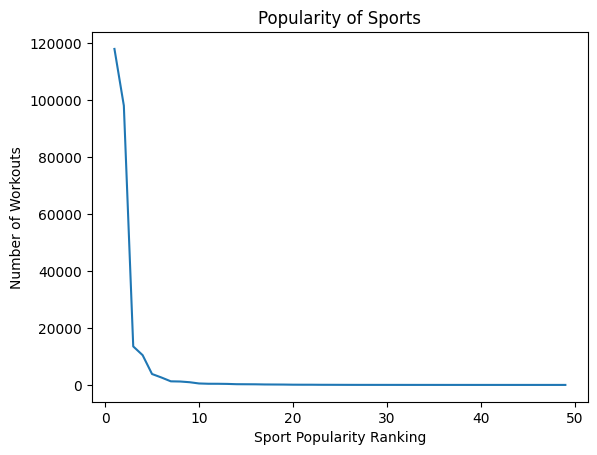

In [ ]:
sns.lineplot(x = "ranking", y = "count", data = sport_rankings)
plt.xlabel("Sport Popularity Ranking")
plt.ylabel("Number of Workouts")
plt.title("Popularity of Sports")
plt.savefig("../figures/Sport_popularity_proportion.png")

The goal is to create a recommendation system that recommends new, less popular sports to users.

In [ ]:
# remove unneeded columns and remove values with NA
data = full.drop(columns=["Unnamed: 0", "id", "timestamp", "weather"])
data = data.dropna()

In [ ]:
# remove outliers
data = data[data["min_heart_rate"] > 40]
data = data[data["max_heart_rate"] < 200]
data = data[data["duration"] < 50000]
data = data[data["distance"] < 250]
data = data[data["descent"] < 20000]
data = data[data["ascent"] < 30000]

<Axes: xlabel='distance', ylabel='descent'>

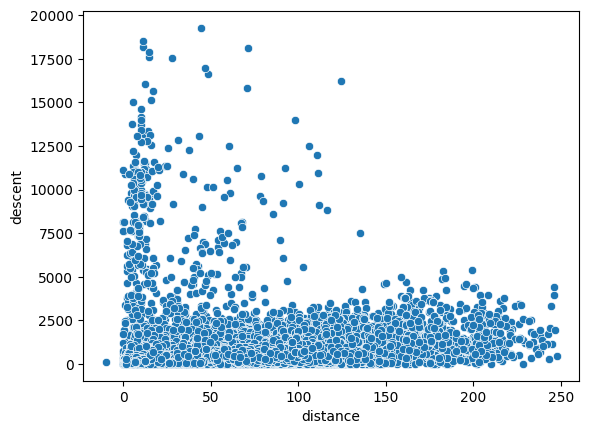

In [ ]:
sns.scatterplot(x = "distance", y = "descent", data = data)

In [ ]:
# add a column that contains each users total number of workouts in the dataset
data["num_workouts"] = data.groupby('userId')['userId'].transform('count')

In [ ]:
data

,userId,sport,ascent,descent,calories,duration,distance,gender,min_heart_rate,avg_heart_rate,max_heart_rate,avg_longitude,avg_latitude,avg_altitude,num_workouts
0,10014612,mountain bike,82.0,94.0,424.000,1904.69,10.76309,male,121,144.698000,171,12.125207,55.663174,32.088000,7
2,10014612,mountain bike,221.0,218.0,1040.000,5241.69,30.25678,male,87,144.190000,164,12.164591,55.630266,36.646800,7
3,10014612,mountain bike,109.0,97.0,538.000,3128.95,11.02767,male,80,129.386000,154,12.125345,55.663086,26.522800,7
4,10014612,mountain bike,208.0,213.0,995.000,5052.78,29.31842,male,105,143.232000,171,12.165625,55.629919,44.270000,7
5,10014612,mountain bike,73.0,82.0,408.000,1694.52,7.08747,male,97,156.642000,171,12.124015,55.664705,28.041200,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253015,9991401,run,124.0,92.0,663.000,2709.41,7.04205,male,125,167.822000,179,17.002307,51.118076,125.693600,12
253016,9991401,run,67.0,150.0,703.603,2404.00,6.44000,male,111,167.907527,178,17.000907,51.099435,148.663226,12
253017,9991401,bike (transport),19.0,12.0,65.000,326.94,1.56399,male,87,145.103093,169,17.001311,51.093018,127.863918,12
253018,9991401,bike (transport),2.0,269.0,60.000,271.74,1.29579,male,105,147.858974,171,17.002066,51.093445,228.997436,12


### Feature engineering

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# remove userId as it should not be scaled
userId = data["userId"].values
data.drop(columns=["userId", "avg_longitude"], inplace=True)

# one-hot-encode categorical features and normalize continuous features
cat_features = data.select_dtypes(include=["object"]).columns
quant_features = data.select_dtypes(include=["number"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), quant_features),  # Scale numeric features
        ('cat', OneHotEncoder(sparse=False, drop=None), cat_features)  # One-hot encode categorical features
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
data_transformed = pipeline.fit_transform(data)

# Create a DataFrame with the transformed data and columns
columns = list(quant_features) + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features))
data_transformed = pd.DataFrame(data_transformed, columns=columns)

data_transformed


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ascent,descent,calories,duration,distance,min_heart_rate,avg_heart_rate,max_heart_rate,avg_latitude,avg_altitude,...,sport_treadmill running,sport_treadmill walking,sport_walk,sport_weight training,sport_wheelchair,sport_windsurfing,sport_yoga,gender_female,gender_male,gender_unknown
0,-0.188293,-0.187069,-0.002122,-0.629690,-0.466046,1.764298,0.360035,0.495533,0.597585,-0.295910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.083435,0.112867,-0.001982,0.246584,0.261227,-0.043614,0.332236,0.108165,0.595998,-0.286347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.135511,-0.179813,-0.002096,-0.308208,-0.456175,-0.415831,-0.477865,-0.445218,0.597581,-0.307585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.058022,0.100773,-0.001992,0.196977,0.226219,0.913516,0.279813,0.495533,0.595981,-0.270354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.205887,-0.216095,-0.002126,-0.684879,-0.603176,0.488125,1.013631,0.495533,0.597659,-0.304400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240734,-0.106188,-0.191907,-0.002068,-0.418376,-0.604871,1.976994,1.625420,0.938240,0.378371,-0.099539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
240735,-0.217616,-0.051614,-0.002059,-0.498575,-0.627332,1.232559,1.630101,0.882901,0.377472,-0.051352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
240736,-0.311450,-0.385414,-0.002204,-1.043997,-0.809247,-0.043614,0.382202,0.384856,0.377162,-0.094986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
240737,-0.344683,0.236228,-0.002206,-1.058492,-0.819253,0.913516,0.533009,0.495533,0.377183,0.117178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# re-add the userId
data_transformed["userId"] = userId

In [ ]:
# create the summary of each user by finding their average of each category
user_summary = data_transformed.groupby("userId").mean()

In [ ]:
user_summary

,ascent,descent,calories,duration,distance,min_heart_rate,avg_heart_rate,max_heart_rate,avg_latitude,avg_altitude,...,sport_treadmill running,sport_treadmill walking,sport_walk,sport_weight training,sport_wheelchair,sport_windsurfing,sport_yoga,gender_female,gender_male,gender_unknown
userId,,,,,,,,,,,,,,,,,,,,,
69,-0.214164,-0.248487,-0.002061,-0.332488,-0.426077,-0.345526,0.140665,0.183647,0.355993,-0.335347,...,0.0,0.0,0.004184,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
2358,-0.254995,-0.303173,-0.002098,-0.442638,-0.535719,-0.699301,-0.416993,-0.739645,0.589608,-0.350392,...,0.0,0.0,0.001751,0.029772,0.0,0.0,0.0,0.0,1.0,0.0
3808,-0.222333,-0.258250,-0.002001,0.179769,-0.177404,-0.336928,-0.053158,-0.772403,0.526366,-0.315357,...,0.0,0.0,0.046083,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
4101,-0.165003,-0.227355,-0.001986,0.076529,-0.142153,-0.063783,0.424253,0.197851,0.524811,-0.302762,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
4434,-0.068875,-0.062384,-0.002022,-0.018619,0.326896,-0.860558,-0.677294,-0.464466,0.600654,-0.277253,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14671923,-0.261549,-0.307258,-0.002100,-0.468065,-0.586566,0.721412,0.822104,0.792570,0.423401,-0.317022,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
14779650,-0.267115,-0.306178,-0.002126,-0.511646,-0.619091,0.172580,1.617980,1.386043,-2.019371,-0.303828,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
15279967,-0.204179,-0.151270,-0.001913,0.293600,-0.282376,-0.614534,0.554308,1.110080,0.268218,-0.242701,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0


## PCA on workout data

In [ ]:
u, s, v = np.linalg.svd(user_summary, full_matrices=False)

### 2D PCA Plot

In [ ]:
data_2d = user_summary @ v[0:2].T
data_2d

,0,1
userId,,
69,-1.330002,0.307956
2358,-0.446791,0.306160
3808,-1.033689,-0.070500
4101,-1.583204,0.153340
4434,-0.169658,-0.531275
...,...,...
14671923,-1.987587,0.998891
14779650,-2.282156,0.175010
15279967,-1.883613,0.122936


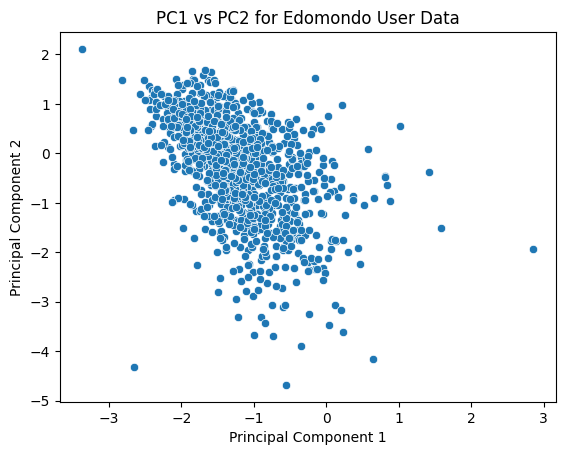

In [ ]:
sns.scatterplot(x = 0, y = 1, data = data_2d)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PC1 vs PC2 for Edomondo User Data")
plt.show()

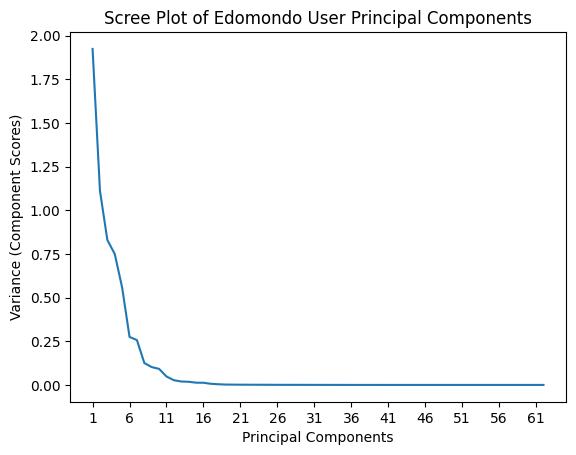

In [ ]:
plt.xticks(np.arange(1, 63, 5))
plt.xlabel("Principal Components")
plt.ylabel("Variance (Component Scores)")
plt.title("Scree Plot of Edomondo User Principal Components")
plt.plot(np.arange(1, 63), s ** 2/user_summary.shape[0])

I chose to include 8 principle components as at that point, the scree plot flattens out and most of the variance is accounted for.

In [ ]:
user_sum_reduced_dimensionality = user_summary @ v[0:8].T

In [ ]:
user_sum_reduced_dimensionality

,0,1,2,3,4,5,6,7
userId,,,,,,,,
69,-1.330002,0.307956,0.399347,0.716098,-0.054098,-0.040517,0.492839,0.135788
2358,-0.446791,0.306160,0.814845,1.517080,0.252363,0.357334,0.554911,-0.104089
3808,-1.033689,-0.070500,0.848697,1.079969,0.061351,-0.084191,0.113134,-0.343676
4101,-1.583204,0.153340,0.571721,0.255776,-0.134858,-0.228119,0.164181,0.077028
4434,-0.169658,-0.531275,1.195222,0.911979,0.065666,0.233692,0.477058,0.199519
...,...,...,...,...,...,...,...,...
14671923,-1.987587,0.998891,-0.088856,-0.040103,-0.190922,0.286719,0.087638,-0.009774
14779650,-2.282156,0.175010,-2.256912,-0.022868,-1.061072,-0.254168,0.867696,0.245180
15279967,-1.883613,0.122936,0.253425,-0.019198,-0.199340,-0.651233,1.042737,0.195810


## Recommendations
### Finding similar users

In [ ]:
from sklearn.neighbors import NearestNeighbors

# use nearest neighbor algorithm to find the other nearest points to each point
nn_model = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn_model.fit(user_sum_reduced_dimensionality)

distances, indices = nn_model.kneighbors(user_sum_reduced_dimensionality)

In [ ]:
distances = distances[:, 1:]
indices = indices[:, 1:]
# indices does not contain the userId number, but the row number
indices[:5]

array([[  73,  311,  366,    9],
       [ 510,  533,  463,  246],
       [ 892,  904,  246,  538],
       [1075,  609,  381,  853],
       [ 701,  114,  463,  277]])

In [ ]:
# create a table that contains recommendations
user_sports = user_summary.iloc[:, 11:-3].applymap(np.ceil)
user_sports_final = 2 * user_sports.copy()

for i in range(user_summary.shape[0]):
  similar_user_average = user_sports.iloc[indices[i]].mean()
  user_sports_final.iloc[i] += similar_user_average

user_sports_final = user_sports_final.applymap(lambda x: 2 if x > 2 else x)

In [ ]:
user_sports_final

,sport_aerobics,sport_badminton,sport_basketball,sport_beach volleyball,sport_bike,sport_bike (transport),sport_circuit training,sport_climbing,sport_core stability training,sport_cross-country skiing,...,sport_swimming,sport_table tennis,sport_tennis,sport_treadmill running,sport_treadmill walking,sport_walk,sport_weight training,sport_wheelchair,sport_windsurfing,sport_yoga
userId,,,,,,,,,,,,,,,,,,,,,
69,0.25,0.0,0.00,0.0,2.00,2.0,0.0,0.0,2.00,0.00,...,2.0,0.0,0.0,0.00,0.0,2.00,0.25,0.0,0.0,0.00
2358,0.00,0.0,0.00,0.0,2.00,2.0,2.0,0.0,2.00,0.00,...,2.0,0.0,0.0,0.00,0.0,2.00,2.00,0.0,0.0,0.00
3808,0.00,0.0,0.00,0.0,2.00,0.0,0.0,0.0,2.00,0.00,...,0.0,0.0,0.0,0.00,0.0,2.00,0.00,0.0,0.0,0.00
4101,0.00,0.0,0.25,0.0,2.00,0.5,0.0,0.0,0.25,0.00,...,0.0,0.0,0.0,0.50,0.0,0.25,0.00,0.0,0.0,0.25
4434,0.25,0.0,0.00,0.0,2.00,2.0,0.0,0.0,1.00,0.00,...,0.0,0.0,0.0,0.25,0.0,0.50,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14671923,0.00,0.0,0.00,0.0,2.00,0.5,0.0,0.0,2.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.50,0.00,0.0,0.0,0.00
14779650,0.00,0.0,0.00,0.0,2.00,0.0,0.0,0.0,0.25,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00
15279967,0.00,0.0,0.00,0.0,0.75,0.5,0.0,0.0,0.00,0.25,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00


If an entry is 2, then that user has done the sport. If the number is 0, then neither the user or any of the other similar users in the system have done the sport. if the entry is between 0 and 1, the user has not done the sport. The value in these cells are the proportion of similar users who have done the sport.

### Reccomendations for each user

In [ ]:
import re
recommendations = {}
sport_extract = re.compile(r"sport_(.+)")

for i in range(user_summary.shape[0]):
  sport_recommendations = user_sports_final.iloc[i].items()
  sport_recommendations = sorted(sport_recommendations, key=lambda x: x[1], reverse=True)
  recommendations[user_summary.index.values[i]] = [sport_extract.search(col).group(1) for col, value in sport_recommendations if 0 < value <= 1]

recommendations

{69: ['elliptical',
  'indoor cycling',
  'aerobics',
  'orienteering',
  'soccer',
  'weight training'],
 2358: ['mountain bike', 'indoor cycling', 'soccer'],
 3808: ['indoor cycling', 'mountain bike'],
 4101: ['bike (transport)',
  'treadmill running',
  'basketball',
  'core stability training',
  'hiking',
  'indoor cycling',
  'orienteering',
  'walk',
  'yoga'],
 4434: ['core stability training',
  'mountain bike',
  'indoor cycling',
  'walk',
  'aerobics',
  'hiking',
  'treadmill running'],
 5197: ['mountain bike',
  'bike (transport)',
  'circuit training',
  'kayaking',
  'rowing'],
 5703: ['core stability training', 'bike (transport)'],
 5844: ['bike (transport)', 'indoor cycling', 'martial arts', 'walk'],
 13653: ['bike',
  'bike (transport)',
  'circuit training',
  'core stability training',
  'cross-country skiing',
  'downhill skiing',
  'indoor cycling',
  'orienteering',
  'scuba diving',
  'walk'],
 16786: ['bike (transport)',
  'core stability training',
  'indoor 

### Number of new sports recommended to each user

In [ ]:
num_recommendations = []
for item in recommendations.values():
  num_recommendations.append(len(item))

Text(0.5, 1.0, 'Proportion of Users and the Number of New Sports they are Recommended')

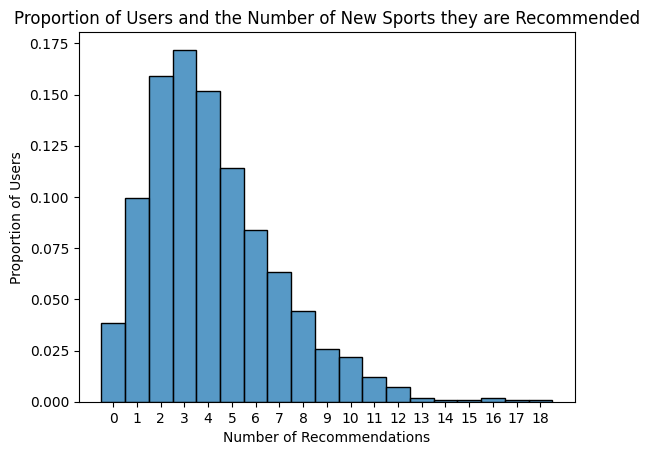

In [ ]:
sns.histplot(num_recommendations, stat='density',
             bins=(np.arange(min(num_recommendations) - 0.5, max(num_recommendations) + 1.5, 1)))
plt.xticks(np.arange(0, max(num_recommendations) + 1))
plt.xlabel("Number of Recommendations")
plt.ylabel("Proportion of Users")
plt.title("Proportion of Users and the Number of New Sports they are Recommended")
plt.savefig("../figures/num_recommendations.png")

In [ ]:
# average number of recommendations
np.mean(num_recommendations)

4.192095588235294

In [ ]:
# proportion of users recommended zero new sport
np.mean(np.array(num_recommendations) == 0)

0.03860294117647059

### Other similar users

Here are other users that are most similar to each user. These could be challengers where we show how what other people with similar profiles are doing for workouts. Or they could be potential connections/workout partners.

In [ ]:
similar_users = pd.DataFrame({"userId":user_summary.index})
for i in range(indices.shape[1]):
  similar_users["Connection" + str(i + 1)] = user_summary.index[indices[:, i]]

similar_users.set_index("userId", inplace=True)

In [ ]:
similar_users

,Connection1,Connection2,Connection3,Connection4
userId,,,,
16786,3235195,2675116,3691161,3559941
22260,139442,5252259,6584414,2435099
56291,68009,196571,2849785,3559941
68009,56291,196571,13165320,854633
69228,5252259,22260,6584414,139442
...,...,...,...,...
13693003,3445572,2226932,993718,8467445
14066832,5629523,5641621,2486861,3700284
14244423,10815918,13469928,2104631,221371


Similar users are sorted by similarity. This means connection1 is more similar to a given user than connection4.